In [1]:
import sys
import os

cur_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(cur_dir)

from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds, DatasetName
from datasets.utils import get_split_indecies
from tools.utils import set_seed
import numpy as np
import h5py

set_seed(1234)

2023-08-27 15:39:03.919594: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-27 15:39:04.073912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 15:39:04.688889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
expand2d = True
train_model = False
reload_module("datasets.fabric")
reload_module("datasets.radio_ml_2018")
from datasets.fabric import make_sigmod_ds, DatasetName
ds = make_sigmod_ds(DatasetName.RADIOML_2018)
radioml2018_data_path = cur_dir + "/data/radioml_2018/GOLD_XYZ_OSC.0001_1024.hdf5"
radioml2018_classes_path = cur_dir + "/data/radioml_2018/classes.txt"
ds.load((radioml2018_data_path, radioml2018_classes_path), expand2d=expand2d)
split_indecies = get_split_indecies(len(ds.get_snrs()), 0.8, 0.1)


In [4]:
from models.fabric import make_sigmod_model, Convolution01xConfiguration, ModelName
from evaluation.results_serialization import load_results

model_name = "cnn_1d_v012_small_radio_ml18"

if train_model:
    cnn_1d_v012_3_configuration = Convolution01xConfiguration(
        input_shape=(1, 1024, 2),
        n_classes=len(ds.get_modulations()),
        output_channels=[32, 48, 64, 96],
        kernel_sizes=[8, 8, 8, 8],
        paddings=["same", "same", "same", "same",],
        max_pool_sizes=[2, 2, 2, 2],
        max_pool_strides=[2, 2, 2, 2],
        avg_size=32,
        dense_sizes=[96],
    )

    model_configuration = cnn_1d_v012_3_configuration

    model = make_sigmod_model(ModelName.CNN_1D_V013, model_configuration)

    model.summary()
else:
    results = load_results(model_name + "_results/", load_model=True)
    model = results["model"]

Test 3


In [5]:
import tensorflow as tf

N_EPOCHS = 25
BATCH_SIZE = 256
# BATCH_SIZE = 1024

if train_model:
    train_gen = ds.to_keras_generator(split_indecies.train, BATCH_SIZE)
    val_gen = ds.to_keras_generator(split_indecies.val, BATCH_SIZE)


    def step_decay(epoch):
        # lrate = 0.001
        # factor = epoch // 8
        # lrate /= 10**factor
        return 0.001
        lrate = 0.001
        if epoch >= 16:
            lrate /= 10
        if epoch >= 24:
            lrate /= 4
        if epoch >= 32:
            lrate /= 4
        if epoch >= 40:
            lrate /= 2
        # factor = epoch // 8
        # lrate /= 10**factor
        return lrate


    lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    # N_EPOCHS = 16


    h = model.fit_generator(
        generator=train_gen,
        validation_data=val_gen,
        
        use_multiprocessing=True,
        workers=12,
        
        epochs=N_EPOCHS,
        callbacks=[lrate]
    )
else:
    class CustomTrainHistory:
        history = results["train_history"]
    h = CustomTrainHistory()


# val_gen = 

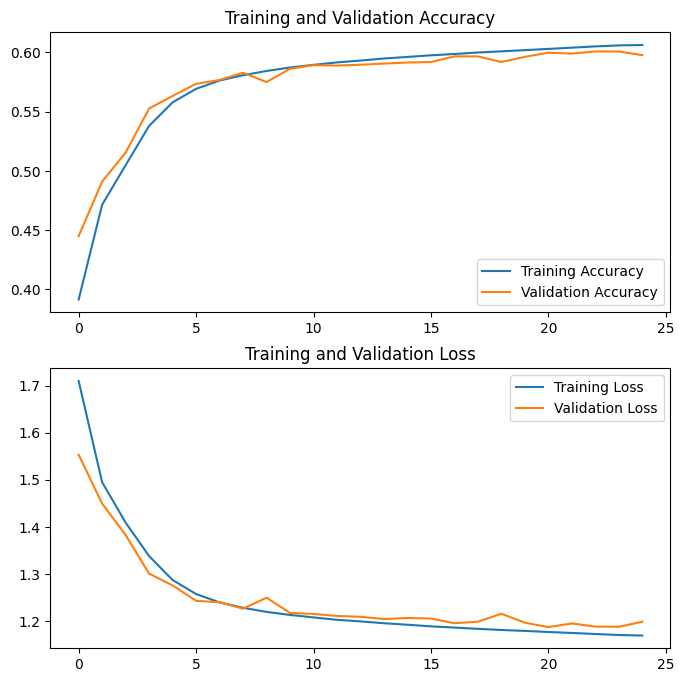

In [7]:
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_train, plot_snr_to_acc
# if train_model:
plot_train(h.history)

2023-08-27 15:43:03.703679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-27 15:43:05.805874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


  1/998 [..............................] - ETA: 54:03

2023-08-27 15:43:06.950232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


998/998 [==============================] - 128s 125ms/step
Preds shape: (255488, 24)
Overall test accuracy: {'Overall': 0.5957109531563126}
32PSK test accuracy: 0.7506522549385016
16APSK test accuracy: 0.6507685142058687
32QAM test accuracy: 0.6895241713363093
FM test accuracy: 0.741872197309417
GMSK test accuracy: 0.7091254752851711
32APSK test accuracy: 0.6398409392160576
OQPSK test accuracy: 0.4740979259399564
8ASK test accuracy: 0.5699598093279746
BPSK test accuracy: 0.6156382477626001
8PSK test accuracy: 0.5952447814284377
AM-SSB-SC test accuracy: 0.45547527446748615
4ASK test accuracy: 0.4497902097902098
16PSK test accuracy: 0.5453609212620542
64APSK test accuracy: 0.5147687163291844
128QAM test accuracy: 0.4380916319575918
128APSK test accuracy: 0.421572315215347
AM-DSB-SC test accuracy: 0.3364059590316574
AM-SSB-WC test accuracy: 0.5226674191121143
64QAM test accuracy: 0.6041077821744866
QPSK test accuracy: 0.6877209746774964
256QAM test accuracy: 0.6725847577674946
AM-DSB-WC t

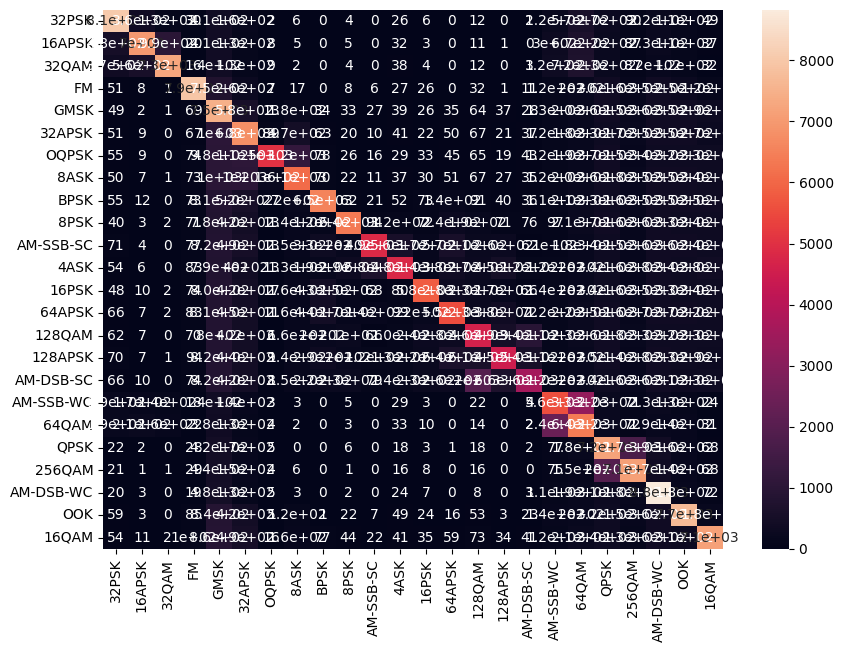

2023-08-27 15:45:17.406368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


998/998 [==============================] - 113s 112ms/step
Preds shape: (255488, 24)
Overall test accuracy: {'Overall': 0.597718875250501}
32PSK test accuracy: 0.7527997062603268
16APSK test accuracy: 0.6488880512627214
32QAM test accuracy: 0.6865016347501167
FM test accuracy: 0.746226680416237
GMSK test accuracy: 0.7041988326115609
32APSK test accuracy: 0.6344105935734791
OQPSK test accuracy: 0.47911477294500865
8ASK test accuracy: 0.5817312114800847
BPSK test accuracy: 0.6131168952327642
8PSK test accuracy: 0.6034499010274296
AM-SSB-SC test accuracy: 0.4647807637906648
4ASK test accuracy: 0.44749491588093915
16PSK test accuracy: 0.5505893446487506
64APSK test accuracy: 0.5136780963087877
128QAM test accuracy: 0.44650986342943855
128APSK test accuracy: 0.43254979703577834
AM-DSB-SC test accuracy: 0.33177480916030533
AM-SSB-WC test accuracy: 0.5198233746711762
64QAM test accuracy: 0.6101315421214666
QPSK test accuracy: 0.6956275914059555
256QAM test accuracy: 0.6641011022424933
AM-DSB-

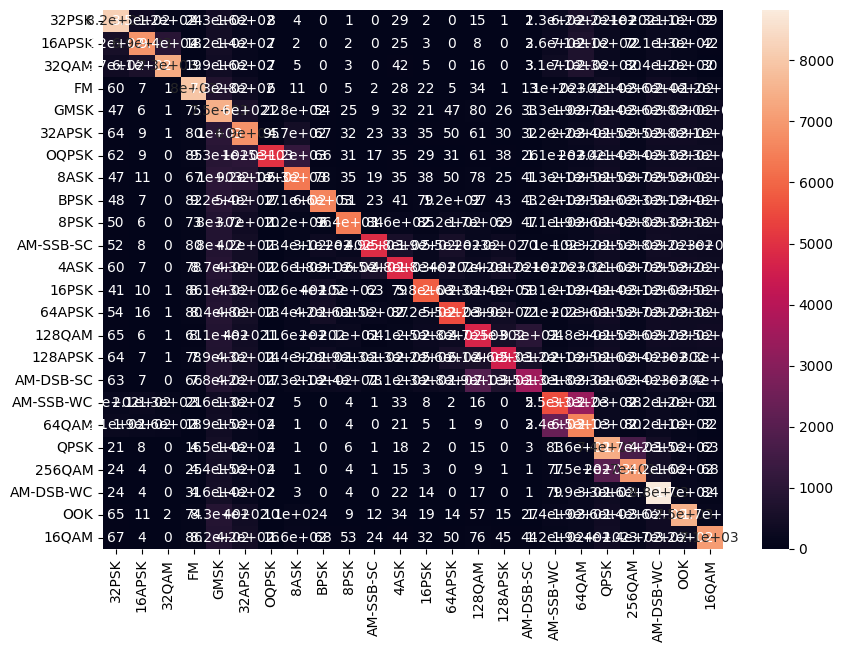

In [8]:
BATCH_SIZE = 256
test_generator = ds.to_keras_generator(split_indecies.test, batch_size=BATCH_SIZE, shuffle=False)
val_generator = ds.to_keras_generator(split_indecies.val, batch_size=BATCH_SIZE, shuffle=False)
# n_test_samples = len(split_indecies.test)
# n_val_samples = len(split_indecies.val)
test_steps = len(test_generator)
val_steps = len(val_generator)
# test_steps = 10
# val_steps = 10
actual_n_test_samples = test_steps * BATCH_SIZE
actual_n_val_samples = val_steps * BATCH_SIZE


def predict_gen(model, generator, *args, **kwargs):
    return model.predict(generator, steps=kwargs["steps"], workers=8)


cm_test, cls_to_acc_test = metric_evaluation(
    model,
    test_generator,
    ds.get_labels()[split_indecies.test][:actual_n_test_samples],
    ds.get_modulations(),
    predict_func=predict_gen,
    predict_kwargs={"steps": test_steps},
)

cm_val, cls_to_acc_val = metric_evaluation(
    model,
    val_generator,
    ds.get_labels()[split_indecies.val][:actual_n_val_samples],
    ds.get_modulations(),
    predict_func=predict_gen,
    predict_kwargs={"steps": val_steps},
)

In [9]:
from sklearn.metrics import accuracy_score
from typing import Dict


def snr_to_metric_evaluation_generator(
    model,
    data_gen,
    labels: np.ndarray,
    snrs: np.ndarray,
    verbose=True,
    metric=accuracy_score,
    predict_args=None,
    predict_kwargs=None,
) -> Dict[float, float]:
    """
    Evaluates model on different snrs

    Returns:
        Dict[str]: Dict snr -> accuracy
    """
    predict_args = [] if predict_args is None else predict_args
    predict_kwargs = {"verbose": 0} if predict_kwargs is None else predict_kwargs

    snr_to_acc = {}
    pred = model.predict(data_gen, workers=8, *predict_args, **predict_kwargs)
    # for snr in range(min(snrs), max(snrs) + 2, 2):
    for snr in sorted(np.unique(snrs)):
        cur_indecies = np.where(snrs == snr)[0]
        cur_labels = labels[cur_indecies]
        cur_pred = pred[cur_indecies]

        cur_pred_labels = np.argmax(cur_pred, axis=1)
        acc = metric(cur_labels, cur_pred_labels)
        verbose and print(f"SNR: {snr} -- Overall test accuracy: {acc}")
        snr_to_acc[float(snr)] = float(acc)
    return snr_to_acc

In [10]:
test_steps = len(test_generator)
val_steps = len(val_generator)
# test_steps = 10
# val_steps = 10
actual_n_test_samples = test_steps * BATCH_SIZE
actual_n_val_samples = val_steps * BATCH_SIZE

snr_to_acc_test = snr_to_metric_evaluation_generator(
    model,
    test_generator,
    ds.get_labels()[split_indecies.test][:actual_n_test_samples],
    ds.get_snrs()[split_indecies.test][:actual_n_test_samples],
    True,
    predict_kwargs={"steps": test_steps}
)

snr_to_acc_val = snr_to_metric_evaluation_generator(
    model,
    val_generator,
    ds.get_labels()[split_indecies.val][:actual_n_val_samples],
    ds.get_snrs()[split_indecies.val][:actual_n_val_samples],
    True,
    predict_kwargs={"steps": val_steps}
)

2023-08-27 15:47:16.019961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


998/998 [==============================] - 94s 94ms/step
SNR: -20 -- Overall test accuracy: 0.04299867225002554
SNR: -18 -- Overall test accuracy: 0.04103802051901026
SNR: -16 -- Overall test accuracy: 0.05360762059181192
SNR: -14 -- Overall test accuracy: 0.06359203575782202
SNR: -12 -- Overall test accuracy: 0.08701500258665287
SNR: -10 -- Overall test accuracy: 0.13601220752797558
SNR: -8 -- Overall test accuracy: 0.19435232639935685
SNR: -6 -- Overall test accuracy: 0.2602196461256864
SNR: -4 -- Overall test accuracy: 0.33107012565869476
SNR: -2 -- Overall test accuracy: 0.41739751172751377
SNR: 0 -- Overall test accuracy: 0.5232840656003239
SNR: 2 -- Overall test accuracy: 0.6189079878665319
SNR: 4 -- Overall test accuracy: 0.7282729383264358
SNR: 6 -- Overall test accuracy: 0.8264932954083706
SNR: 8 -- Overall test accuracy: 0.8862169477409952
SNR: 10 -- Overall test accuracy: 0.9193021832279127
SNR: 12 -- Overall test accuracy: 0.931635926222935
SNR: 14 -- Overall test accuracy:

2023-08-27 15:48:55.379280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


998/998 [==============================] - 89s 89ms/step
SNR: -20 -- Overall test accuracy: 0.03955600403632694
SNR: -18 -- Overall test accuracy: 0.042522743534703054
SNR: -16 -- Overall test accuracy: 0.05197441884072683
SNR: -14 -- Overall test accuracy: 0.0626421335538557
SNR: -12 -- Overall test accuracy: 0.08904179932217315
SNR: -10 -- Overall test accuracy: 0.13724696356275304
SNR: -8 -- Overall test accuracy: 0.19218207797509695
SNR: -6 -- Overall test accuracy: 0.2621914509331728
SNR: -4 -- Overall test accuracy: 0.32585535750870726
SNR: -2 -- Overall test accuracy: 0.4213047910295617
SNR: 0 -- Overall test accuracy: 0.5272355646397547
SNR: 2 -- Overall test accuracy: 0.6217088146529296
SNR: 4 -- Overall test accuracy: 0.722531082583645
SNR: 6 -- Overall test accuracy: 0.8295982232990107
SNR: 8 -- Overall test accuracy: 0.8911723020854424
SNR: 10 -- Overall test accuracy: 0.9214528717230338
SNR: 12 -- Overall test accuracy: 0.9349350381521964
SNR: 14 -- Overall test accuracy: 

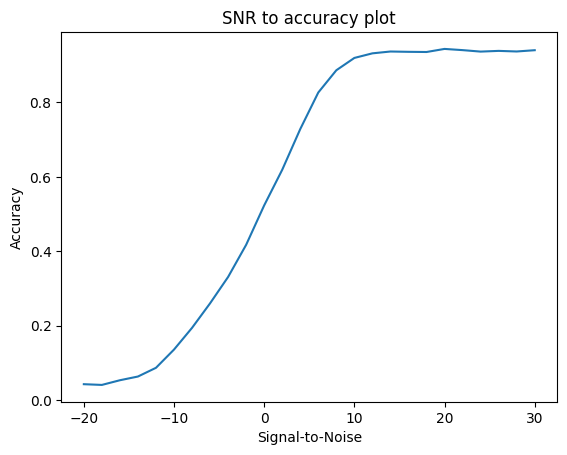

In [11]:
plot_snr_to_acc(snr_to_acc_test)

In [12]:
from evaluation.results_serialization import dump_results

from copy import deepcopy


if train_model:
    history = deepcopy(h.history)
    history["lr"] = list(map(lambda x: float(x), history["lr"]))

    dump_results(
        model_name + "_results/",
        model=model,
        model_config=model_configuration,
        model_name=ModelName.CNN_1D_V012,
        dataset_name=DatasetName.RADIOML_2016,
        dataset_path=radioml2018_data_path + " " + radioml2018_classes_path,
        train_history=history,
        cm_test=cm_test,
        cls_to_acc_test=cls_to_acc_test,
        snr_to_acc_test=snr_to_acc_test,
        cm_val=cm_val,
        cls_to_acc_val=cls_to_acc_val,
        snr_to_acc_val=snr_to_acc_val,
        short_description="Smaller + dense, 48 epochs with more decay (16:/=10, 24:/=4, 32: /=4)",
        dump_model=True,
    )

# TF lite quantization

In [14]:
# let's create representative dataset from generator
repr_ds_size = 4000

if not train_model:
    train_gen = ds.to_keras_generator(split_indecies.train, BATCH_SIZE)

n_samples = int(np.ceil(repr_ds_size / train_gen.batch_size))
print(n_samples)

if expand2d:
    repr_X = np.empty((n_samples * BATCH_SIZE, 1, 1024, 2), dtype=np.float32)
else:
    repr_X = np.empty((n_samples * BATCH_SIZE, 1024, 2), dtype=np.float32)
repr_y = np.empty((n_samples * BATCH_SIZE,), dtype=np.uint8)
for i in range(n_samples):
    repr_X[i * BATCH_SIZE : (i + 1) * BATCH_SIZE], repr_y[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = train_gen[i]

16


In [15]:
# reload_module("deployment_tools")
reload_module("models.layers.custom_batch_norm")
from deployment_tools import to_tf_lite, predict_tflite
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from tqdm import trange

model_path = f"{model_name}_results/model_original"
model.save(model_path)

model_tflile = to_tf_lite(model_path, apply_quantization=True, representative_ds=repr_X)


INFO:tensorflow:Assets written to: cnn_1d_v012_small_radio_ml18_results/model_original/assets


INFO:tensorflow:Assets written to: cnn_1d_v012_small_radio_ml18_results/model_original/assets
2023-08-27 16:08:27.914411: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-27 16:08:27.914444: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-27 16:08:27.917067: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_1d_v012_small_radio_ml18_results/model_original
2023-08-27 16:08:27.918752: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-08-27 16:08:27.918770: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_1d_v012_small_radio_ml18_results/model_original
2023-08-27 16:08:27.925633: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-08-27 16:08:27.927264: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedM

In [9]:
X0, y0 = test_generator[0]
print(X0.shape)
print(y0.shape) 

y0_pred = np.argmax(predict_tflite(model_tflile, X0), axis=1)
y0_pred2 = np.argmax(model.predict(X0), axis=1)
print(y0)
print(y0_pred)
print(y0_pred2)

NameError: name 'test_generator' is not defined

In [27]:
def predict_tflite_gen(model, generator, *args, **kwargs):
    bs = generator.batch_size
    pred = np.empty((len(generator) * bs, generator.n_classes), dtype=np.float32)
    for i in trange(len(generator)):
        pred[i*bs:(i+1)*bs] = predict_tflite(model, generator[i][0])
    return pred


  0%|          | 0/998 [00:00<?, ?it/s]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
100%|██████████| 998/998 [02:23<00:00,  6.94it/s]


Preds shape: (255488, 24)
Overall test accuracy: {'Overall': 0.10631810495991983}
32PSK test accuracy: 0.1925083861349236
16APSK test accuracy: 0.09194224499301351
32QAM test accuracy: 0.28521227087092793
FM test accuracy: 0.0015881913303437967
GMSK test accuracy: 0.0010456273764258555
32APSK test accuracy: 0.0007574323044877864
OQPSK test accuracy: 0.0058717681598636235
8ASK test accuracy: 0.0
BPSK test accuracy: 0.0
8PSK test accuracy: 0.0
AM-SSB-SC test accuracy: 0.0
4ASK test accuracy: 0.0
16PSK test accuracy: 0.0
64APSK test accuracy: 0.0005573100501579045
128QAM test accuracy: 0.0
128APSK test accuracy: 0.0
AM-DSB-SC test accuracy: 0.0
AM-SSB-WC test accuracy: 0.026147479307750188
64QAM test accuracy: 0.3262671942717166
QPSK test accuracy: 0.5715241280458672
256QAM test accuracy: 0.3957880819718576
AM-DSB-WC test accuracy: 0.5651762031072376
OOK test accuracy: 0.1041319251435983
16QAM test accuracy: 0.0
Confusion matrix:
[[ 2066   359   507     0     0     4     0     0     2    

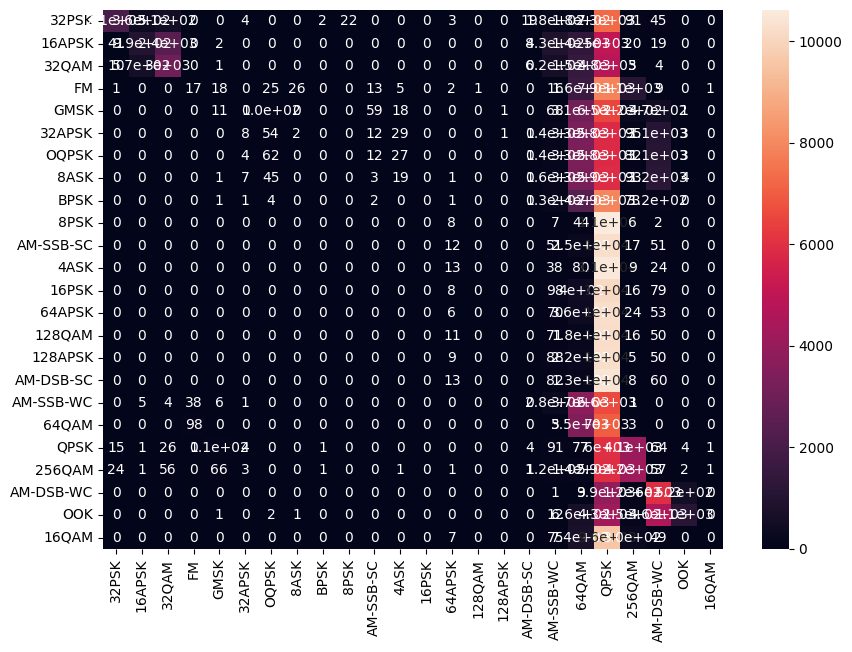

In [16]:



cm_test_tflite, cls_to_acc_test_tflite = metric_evaluation(
    model_tflile,
    test_generator,
    ds.get_labels()[split_indecies.test][:actual_n_test_samples],
    ds.get_modulations(),
    predict_func=predict_tflite_gen,
    predict_kwargs={"steps": test_steps},
)


In [17]:
# TODO: reuse previous function, add predict_func argument
def snr_to_metric_evaluation_generator_tflite(
    model,
    data_gen,
    labels: np.ndarray,
    snrs: np.ndarray,
    verbose=True,
    metric=accuracy_score,
    predict_args=None,
    predict_kwargs=None,
) -> Dict[float, float]:
    """
    Evaluates model on different snrs

    Returns:
        Dict[str]: Dict snr -> accuracy
    """
    predict_args = [] if predict_args is None else predict_args
    predict_kwargs = {"verbose": 0} if predict_kwargs is None else predict_kwargs

    snr_to_acc = {}
    # pred = model.predict(data_gen, workers=8, *predict_args, **predict_kwargs)
    pred = predict_tflite_gen(model, data_gen, *predict_args, **predict_kwargs)
    # for snr in range(min(snrs), max(snrs) + 2, 2):
    for snr in sorted(np.unique(snrs)):
        cur_indecies = np.where(snrs == snr)[0]
        cur_labels = labels[cur_indecies]
        cur_pred = pred[cur_indecies]

        cur_pred_labels = np.argmax(cur_pred, axis=1)
        acc = metric(cur_labels, cur_pred_labels)
        verbose and print(f"SNR: {snr} -- Overall test accuracy: {acc}")
        snr_to_acc[float(snr)] = float(acc)
    return snr_to_acc

100%|██████████| 998/998 [01:56<00:00,  8.57it/s]


SNR: -20 -- Overall test accuracy: 0.04238586456950261
SNR: -18 -- Overall test accuracy: 0.04123918728626031
SNR: -16 -- Overall test accuracy: 0.04154843940008107
SNR: -14 -- Overall test accuracy: 0.04276716781796018
SNR: -12 -- Overall test accuracy: 0.04138644593895499
SNR: -10 -- Overall test accuracy: 0.0404883011190234
SNR: -8 -- Overall test accuracy: 0.043211737513817704
SNR: -6 -- Overall test accuracy: 0.043319097010372176
SNR: -4 -- Overall test accuracy: 0.04894608836643697
SNR: -2 -- Overall test accuracy: 0.07250662859473792
SNR: 0 -- Overall test accuracy: 0.09182020651953837
SNR: 2 -- Overall test accuracy: 0.11183013144590495
SNR: 4 -- Overall test accuracy: 0.12516402543656
SNR: 6 -- Overall test accuracy: 0.14709467696058512
SNR: 8 -- Overall test accuracy: 0.1597959608577972
SNR: 10 -- Overall test accuracy: 0.14670475413180983
SNR: 12 -- Overall test accuracy: 0.14895749799518845
SNR: 14 -- Overall test accuracy: 0.1524439918533605
SNR: 16 -- Overall test accurac

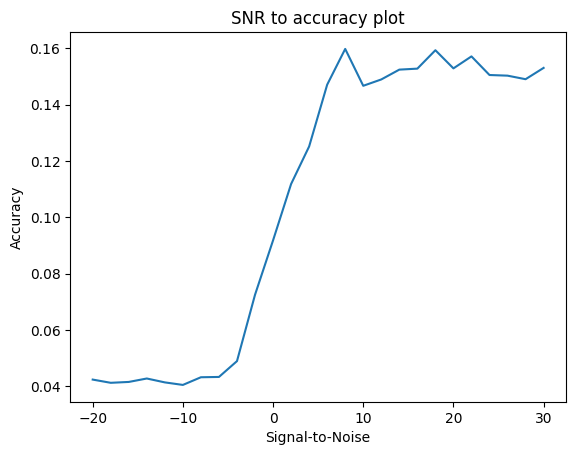

In [18]:
snr_to_acc_test_tflite = snr_to_metric_evaluation_generator_tflite(
    model_tflile,
    test_generator,
    ds.get_labels()[split_indecies.test][:actual_n_test_samples],
    ds.get_snrs()[split_indecies.test][:actual_n_test_samples],
    True,
)

plot_snr_to_acc(snr_to_acc_test_tflite)

# Quantization aware fine-tuning

In [29]:
import tensorflow_model_optimization as tfmot
quantize_model = tfmot.quantization.keras.quantize_model

In [31]:
print("Model is quantization aware")
q_aware_model = quantize_model(model)

q_aware_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

Model is quantization aware


In [34]:
if not train_model:
    train_gen = ds.to_keras_generator(split_indecies.train, BATCH_SIZE)
    val_gen = ds.to_keras_generator(split_indecies.val, BATCH_SIZE)

q_aware_model.fit(
    x=train_gen,
    validation_data=val_gen,
    epochs=6,
    batch_size=BATCH_SIZE,
    workers=12
)

    # h = model.fit_generator(
    #     generator=train_gen,
    #     validation_data=val_gen,
        
    #     use_multiprocessing=True,
    #     workers=12,
        
    #     epochs=N_EPOCHS,
    #     callbacks=[lrate]
    # )


Epoch 1/6


2023-08-27 16:39:12.459345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-27 16:39:14.705934: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x350f2430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-27 16:39:14.705954: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2023-08-27 16:39:14.989312: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7985/7987 [============================>.] - ETA: 0s - loss: 1.6051 - accuracy: 0.4505

2023-08-27 16:51:02.934789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7987/7987 [==============================] - 789s 98ms/step - loss: 1.6052 - accuracy: 0.4505 - val_loss: 1.8210 - val_accuracy: 0.3863
Epoch 2/6
7987/7987 [==============================] - 713s 89ms/step - loss: 1.9236 - accuracy: 0.3786 - val_loss: 2.0848 - val_accuracy: 0.3626
Epoch 3/6
7987/7987 [==============================] - 700s 88ms/step - loss: 2.4088 - accuracy: 0.3456 - val_loss: 2.6405 - val_accuracy: 0.3239
Epoch 4/6
7987/7987 [==============================] - 673s 84ms/step - loss: 2.7727 - accuracy: 0.2712 - val_loss: 3.1113 - val_accuracy: 0.2608
Epoch 5/6
6289/7987 [======================>.......] - ETA: 2:03 - loss: 2.7587 - accuracy: 0.2277

KeyboardInterrupt: 

In [41]:
model_q_aware_path = f"{model_name}_results/model__q_aware"
q_aware_model.save(model_q_aware_path)

model_tflile_q_aware = to_tf_lite(model_q_aware_path, apply_quantization=True, representative_ds=repr_X)


INFO:tensorflow:Assets written to: cnn_1d_v012_small_radio_ml18_results/model__q_aware/assets


INFO:tensorflow:Assets written to: cnn_1d_v012_small_radio_ml18_results/model__q_aware/assets
2023-08-27 17:44:16.723455: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-27 17:44:16.723480: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-27 17:44:16.723655: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_1d_v012_small_radio_ml18_results/model__q_aware
2023-08-27 17:44:16.727187: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-08-27 17:44:16.727201: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_1d_v012_small_radio_ml18_results/model__q_aware
2023-08-27 17:44:16.737771: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-27 17:44:16.859312: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at

100%|██████████| 998/998 [01:58<00:00,  8.43it/s]


Preds shape: (255488, 24)
Overall test accuracy: {'Overall': 0.08039516533066132}
32PSK test accuracy: 0.9231270965337309
16APSK test accuracy: 0.024126688402421985
32QAM test accuracy: 0.30164308101434134
FM test accuracy: 0.0
GMSK test accuracy: 0.0
32APSK test accuracy: 0.0
OQPSK test accuracy: 0.0
8ASK test accuracy: 0.0
BPSK test accuracy: 0.0
8PSK test accuracy: 0.0
AM-SSB-SC test accuracy: 0.0
4ASK test accuracy: 0.0
16PSK test accuracy: 0.0
64APSK test accuracy: 0.0
128QAM test accuracy: 0.0
128APSK test accuracy: 0.0
AM-DSB-SC test accuracy: 0.0
AM-SSB-WC test accuracy: 0.3354025583145222
64QAM test accuracy: 0.3143960806482005
QPSK test accuracy: 0.020926899187768754
256QAM test accuracy: 0.007082821796203608
AM-DSB-WC test accuracy: 9.473285335354301e-05
OOK test accuracy: 0.0
16QAM test accuracy: 0.0
Confusion matrix:
[[ 9907    31   436     0     0     0     0     0     0    45     0    45
     52     0     0     0     3   100     3     0   110     0     0     0]
 [ 7473  

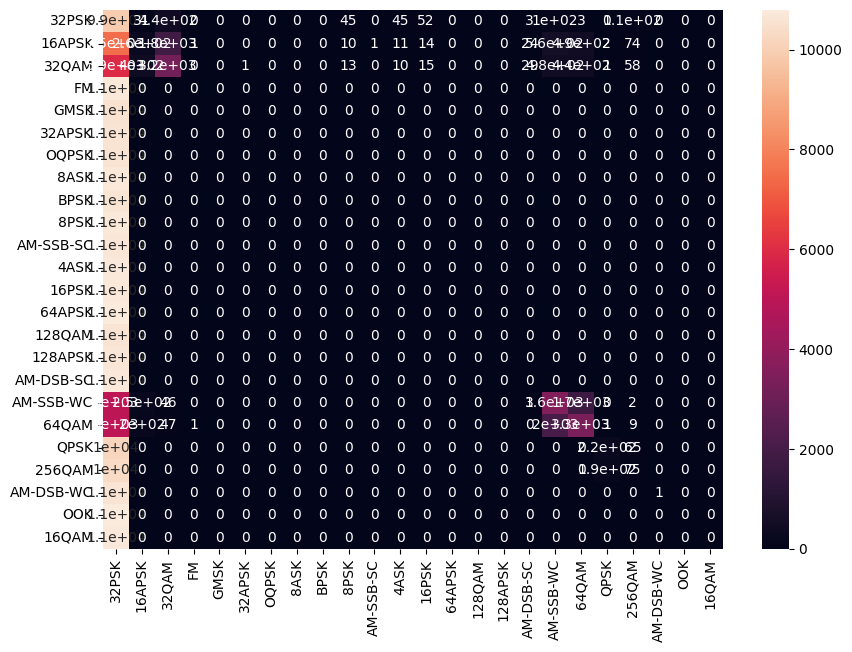

In [42]:
cm_test_tflite, cls_to_acc_test_tflite = metric_evaluation(
    model_tflile_q_aware,
    test_generator,
    ds.get_labels()[split_indecies.test][:actual_n_test_samples],
    ds.get_modulations(),
    predict_func=predict_tflite_gen,
    predict_kwargs={"steps": test_steps},
)


100%|██████████| 998/998 [01:54<00:00,  8.75it/s]


SNR: -20 -- Overall test accuracy: 0.03911755694004698
SNR: -18 -- Overall test accuracy: 0.04335143834238584
SNR: -16 -- Overall test accuracy: 0.04225780299959465
SNR: -14 -- Overall test accuracy: 0.04246241365298659
SNR: -12 -- Overall test accuracy: 0.04138644593895499
SNR: -10 -- Overall test accuracy: 0.041810783316378435
SNR: -8 -- Overall test accuracy: 0.04090041201889257
SNR: -6 -- Overall test accuracy: 0.04179377669310555
SNR: -4 -- Overall test accuracy: 0.042663153627888126
SNR: -2 -- Overall test accuracy: 0.04925555782174179
SNR: 0 -- Overall test accuracy: 0.051832354727677665
SNR: 2 -- Overall test accuracy: 0.05187057633973711
SNR: 4 -- Overall test accuracy: 0.06389421621076007
SNR: 6 -- Overall test accuracy: 0.09995936611133685
SNR: 8 -- Overall test accuracy: 0.10826566729127629
SNR: 10 -- Overall test accuracy: 0.11487451540501939
SNR: 12 -- Overall test accuracy: 0.11868484362469928
SNR: 14 -- Overall test accuracy: 0.12067209775967414
SNR: 16 -- Overall test 

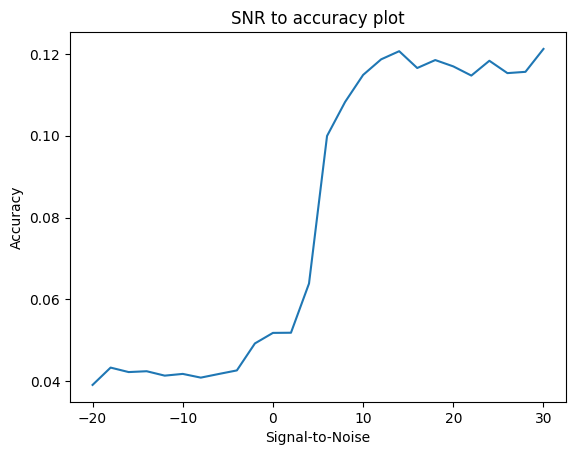

In [43]:
snr_to_acc_test_tflite = snr_to_metric_evaluation_generator_tflite(
    model_tflile_q_aware,
    test_generator,
    ds.get_labels()[split_indecies.test][:actual_n_test_samples],
    ds.get_snrs()[split_indecies.test][:actual_n_test_samples],
    True,
)

plot_snr_to_acc(snr_to_acc_test_tflite)

In [10]:
from deployment_tools import deploy_model_tflite

deploy_model_tflite(
    model_tflile,
    test_data=repr_X,
    test_labels=repr_y,
    model_name=model_name,
    classes=ds.get_modulations(),
    epsilon=20,
    apply_quantization=True,
    arena_size=200_000, 
    create_cfu_playground_proj=True
)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


[debug] Export test data


24it [00:00, 648.22it/s]


RuntimeError: project directory already exists